<a href="https://colab.research.google.com/github/dtype2100/DeepLearning/blob/master/Real_Time_Face_Mask_Detector_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 face mask detector with CNN, OpenCV

In [ ]:
import cv2,os
import numpy as np
from keras.utils import np_utils
import imutils
import pytesseract
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
%matplotlib inline

# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [ ]:
np.__version__

'1.19.5'

In [ ]:
cv2.__version__

'4.6.0'

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
keras.__version__

'2.6.0'

#### 데이터 라벨 만들기

In [ ]:
data_path='../data/mask_data/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

In [ ]:
label_dict

{'without_mask': 0, 'with_mask': 1}

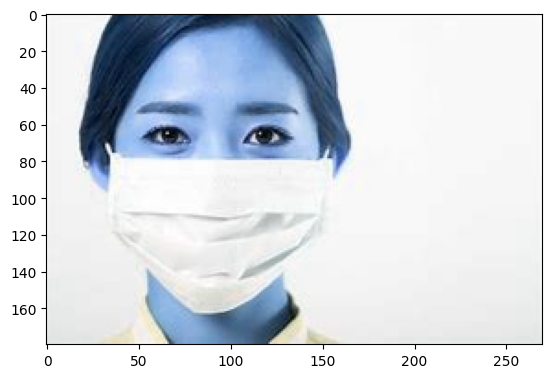

In [ ]:
img = cv2.imread('../data/mask_data/with_mask/601-with-mask.jpg')
plt.imshow(img)

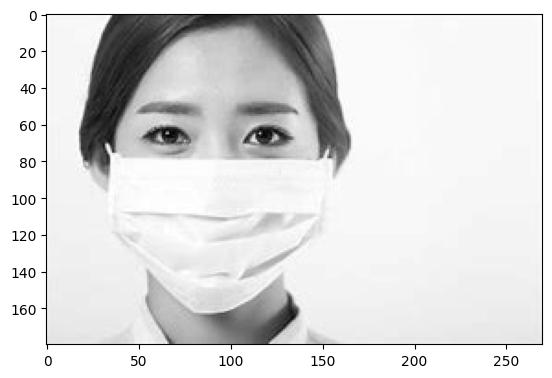

In [ ]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

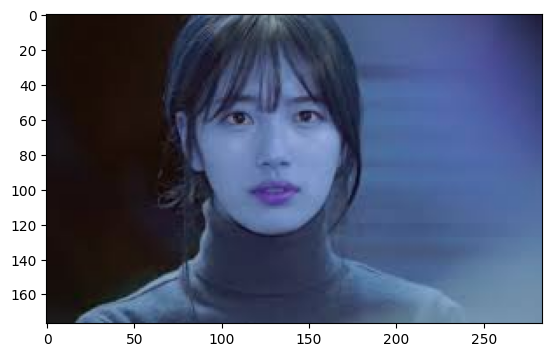

In [ ]:
img = cv2.imread('../data/mask_data/without_mask/551.jpg')
plt.imshow(img)

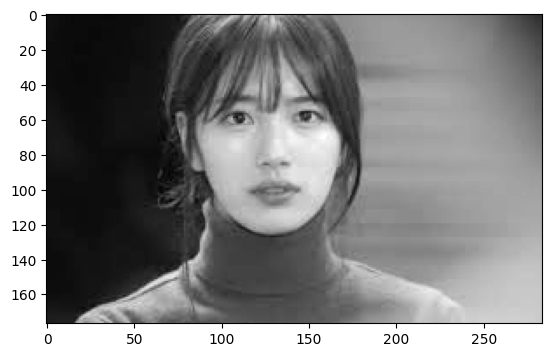

In [ ]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = 'gray')

### #데이터 불러오기

In [ ]:
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            resized=cv2.resize(gray,(100, 100))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

Exception: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Exception: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



In [ ]:
categories

['without_mask', 'with_mask']

In [ ]:
folder_path

'../data/mask_data/with_mask'

In [ ]:
img_names[:5]

['0-with-mask.jpg',
 '101-with-mask.jpg',
 '106-with-mask.jpg',
 '108-with-mask.jpg',
 '109-with-mask.jpg']

In [ ]:
data[:3]

[array([[218, 215, 212, ..., 168, 155, 152],
        [215, 212, 204, ..., 189, 183, 159],
        [201, 198, 190, ..., 162, 167, 158],
        ...,
        [ 33,  53,  70, ...,  14,  14,  15],
        [ 31,  54,  77, ...,  19,  19,  17],
        [ 33,  56,  77, ...,  25,  27,  23]], dtype=uint8),
 array([[180, 173, 175, ..., 186, 163, 137],
        [178, 174, 175, ..., 174, 151, 135],
        [174, 178, 177, ..., 153, 134, 145],
        ...,
        [203, 201, 196, ..., 153, 152, 161],
        [201, 200, 195, ..., 159, 156, 159],
        [194, 196, 199, ..., 155, 166, 143]], dtype=uint8),
 array([[255, 255, 255, ..., 254, 254, 254],
        [255, 255, 255, ..., 254, 254, 254],
        [254, 254, 250, ..., 228, 218, 209],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]

In [ ]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0], 100, 100, 1))
target=np.array(target)

new_target=np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)

In [ ]:
new_target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
data=np.load('./data.npy')
target=np.load('./target.npy')

In [ ]:
data.shape

(615, 100, 100, 1)

In [ ]:
target.shape

(615, 2)

In [ ]:
!pip install sklearn


[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop

### #학습용 데이터와 검증용 데이터 세트로 분할하기

In [ ]:
train_data,test_data,train_target,test_target=train_test_split(data,target, test_size=0.2, random_state=42)

In [ ]:
train_data.shape

(492, 100, 100, 1)

### *Data augmentation to improve generalization

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.2, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15, 
                         horizontal_flip=True,
                         fill_mode="nearest")

### *Hyperparameter Tuning With Bayesian Optimization

In [ ]:
input_shape=data.shape[1:]
input_shape

(100, 100, 1)

In [ ]:
def get_model(input_shape, dropout2_rate=0.5):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     name="conv2d_1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name="conv2d_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="maxpool2d_1"))
    model.add(Dropout(0.25, name="dropout_1"))
    model.add(Flatten(name="flatten"))
    model.add(Dense(128, activation='relu', name="dense_1"))
    model.add(Dropout(dropout2_rate, name="dropout_2"))
    model.add(Dense(2, activation='softmax', name="dense_2"))
    return model

In [ ]:
def fit_with(input_shape, verbose, dropout2_rate, lr):

    model = get_model(input_shape, dropout2_rate)
    
    optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model.fit(train_data, train_target, epochs=10,
              batch_size=4, verbose=verbose)

    score = model.evaluate(test_data, test_target, steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return score[1]

In [ ]:
from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [ ]:
pip install bayesian-optimization


[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from bayes_opt import BayesianOptimization

pbounds = {'dropout2_rate': (0.1, 0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2, 
    random_state=1,
)

#optimizer.maximize(init_points=10, n_iter=10)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

In [ ]:
print(optimizer.max)

{}


### * Build the CNN model

In [ ]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=data.shape[1:], activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1942))
model.add(Dense(2, activation='softmax'))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint = ModelCheckpoint(
    '{epoch:03d}-{val_loss:.4f}.model',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

### *Train the model

In [ ]:
history=model.fit(aug.flow(train_data, train_target), 
                  epochs=10, 
                  batch_size=4,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(test_data, test_target))

print(model.evaluate(test_data,test_target))

Epoch 1/10
16/16 [==============================] - 7s 436ms/step - loss: 0.6813 - accuracy: 0.5915 - val_loss: 0.6330 - val_accuracy: 0.6829
INFO:tensorflow:Assets written to: 001-0.6330.model\assets
Epoch 2/10
16/16 [==============================] - 7s 452ms/step - loss: 0.6695 - accuracy: 0.6321 - val_loss: 0.6450 - val_accuracy: 0.6748
Epoch 3/10
16/16 [==============================] - 7s 434ms/step - loss: 0.6639 - accuracy: 0.6321 - val_loss: 0.6120 - val_accuracy: 0.6911
INFO:tensorflow:Assets written to: 003-0.6120.model\assets
Epoch 4/10
16/16 [==============================] - 7s 436ms/step - loss: 0.6525 - accuracy: 0.6321 - val_loss: 0.6066 - val_accuracy: 0.6911
INFO:tensorflow:Assets written to: 004-0.6066.model\assets
Epoch 5/10
16/16 [==============================] - 7s 414ms/step - loss: 0.6401 - accuracy: 0.6484 - val_loss: 0.5849 - val_accuracy: 0.6911
INFO:tensorflow:Assets written to: 005-0.5849.model\assets
Epoch 6/10
 4/16 [======>.......................] - ET

In [ ]:
model.summary()

### *Evaluate the model : best model (100-0.3327.model)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()

# COVID-19 face mask detector in real-time video streams with OpenCV

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

labels_dict={1:'with_mask', 0:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
#video stream source : webcam or recorded video 

source = cv2.VideoCapture('../data/video.mp4')

In [ ]:
# video output

fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
out = cv2.VideoWriter('output.avi', fourcc, 20, (640,480))

In [ ]:
# warning sound in case of without_mask

import pygame, sys
from pygame import mixer

pygame.init()
pygame.mixer.init()

sound = mixer.Sound('alarm.wav')

In [ ]:
#!sudo chown -R {user} {100-0.3327.model}

In [ ]:
face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')


In [ ]:
import cv2
import time
import numpy as np
from keras.models import load_model
from twilio.rest import Client

import pygame, sys
from pygame import mixer
pygame.init()
pygame.mixer.init()
sound = mixer.Sound('alarm.wav')

model = load_model('../100-0.3327.model')
face_clsfr=cv2.CascadeClassifier('../haarcascade_frontalface_default.xml')

#source=cv2.VideoCapture(0)
source=cv2.VideoCapture('../data/video.mp4')

fourcc = cv2.VideoWriter_fourcc('X', 'V', 'I', 'D')
out = cv2.VideoWriter('output.avi', fourcc, 20, (320,240))

labels_dict={1:'with_mask', 0:'without_mask'}
color_dict={1:(0,255,0), 0:(0,0,255)}

#account_sid = "ACxxxxxxxxxXxxxx"
#auth_token  = "93xxxxxxxxxxx"

#myTwilioNumber = "+1xxxxxxxx"
#destCellPhone  = "+82010xxxxxxxx"

while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3, 5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-30),(x+w,y),color_dict[label],-1)
        
        if(labels_dict[label] == 'with_mask'):
            print("No Beep")
        else:
            sound.play()
            print("Beep")

            #client = Client(account_sid, auth_token)
            #client.messages.create(body = 'Test MSG: No Mask', 
            #                       from_ = myTwilioNumber, 
             #                      to = destCellPhone)
            #time.sleep(2)
           
        cv2.putText(
          img, "{}: {:.2f}%".format(labels_dict[label], np.max(result) * 100),
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),2)
        
        
    cv2.imshow('Mask Detector LIVE',img)
    out.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

source.release()
out.release()
cv2.destroyAllWindows()

writeVideo()

Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
No Beep
No Beep
No Beep
No Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
No Beep
Beep
No Beep
Beep
Beep
No Beep
Beep
Beep
Beep
Beep
Beep
Beep
No Beep
Beep
Beep
Beep
No Beep
Beep
No Beep
Beep
Beep
Beep
Beep
No Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
No Beep
Beep
No Beep
Beep
No Beep
Beep
No Beep
Beep
No Beep
No Beep
Beep
No Beep
No Beep
Beep
No Beep
Beep
No Beep
Beep
No Beep
Beep
No 

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
cv2.destroyAllWindows()

In [ ]:
# face recognition/classifier : haar feature
#face_clsfr=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

# face mask detector
model = load_model('../100-0.3327.model')

while(True):

    ret,img=source.read()
    #gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        
        if(labels_dict[label] == 'with_mask'):
            print("No Beep")
        else:
            sound.play()
            print("Beep")   
        
        cv2.putText(
          img, "{}: {:.2f}%".format(labels_dict[label], np.max(result) * 100),            
          (x, y-10),
          cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,255,255),2)
        
        
    #cv2.imshow('LIVE',img)
    out.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

source.release()
out.release()

cv2.destroyAllWindows()

#### Example : capturing a video

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('capture_result.png')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)